In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Resnet50 import

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import os
from keras.models import load_model
import torch

In [ ]:
def resize_image(image_path, target_size=(224, 224)):
  img = load_img(image_path, target_size = target_size)
  img_array = img_to_array(img) / 255.0
  return img_array

In [ ]:
# train_directory, Test_directory 설정

base_dir = '/content/drive/MyDrive/dataset/Dataset'
train_dir = base_dir + '/Train'
val_dir = base_dir + '/Test'

In [ ]:
img_size = (224, 224)
batch_size = 32
num_classes = 5
disgust_classes = ['skin','trypophobia', 'other', 'insect', 'deadbody']

In [ ]:
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode='nearest',
)

val_data = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=True,
)

val_generator = val_data.flow_from_directory(
    val_dir,
    target_size = img_size,
    batch_size = batch_size,
    # Val_accuracy가 50%로 고정되는 상황을 막기 위함.
    class_mode = 'categorical',
    shuffle=False,
)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,), pooling = 'avg')
base_model.trainable = False

In [ ]:
input = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(input)
x = base_model(input, training = False)

x = Dropout(0.5)(x)

outputs = Dense(5, activation='softmax')(x)

model = Model(input, outputs)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# callbacks = [
#    EarlyStopping(patience=10, restore_best_weights=True),
#    ModelCheckpoint('best_model.h5', save_best_only=True)
#

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // val_generator.batch_size,
    verbose = 1,
    epochs = 50
)

Epoch 1/50
46/46 [==============================] - 41s 695ms/step - loss: 1.2481 - accuracy: 0.3794 - val_loss: 0.9382 - val_accuracy: 0.6042
Epoch 2/50
46/46 [==============================] - 33s 723ms/step - loss: 0.9762 - accuracy: 0.5129 - val_loss: 0.8891 - val_accuracy: 0.5868
Epoch 3/50
46/46 [==============================] - 30s 635ms/step - loss: 0.8787 - accuracy: 0.5851 - val_loss: 0.8086 - val_accuracy: 0.6944
Epoch 4/50
46/46 [==============================] - 28s 612ms/step - loss: 0.8418 - accuracy: 0.6015 - val_loss: 0.7705 - val_accuracy: 0.7118
Epoch 5/50
46/46 [==============================] - 31s 677ms/step - loss: 0.8257 - accuracy: 0.6335 - val_loss: 0.7417 - val_accuracy: 0.6875
Epoch 6/50
46/46 [==============================] - 30s 664ms/step - loss: 0.8092 - accuracy: 0.6124 - val_loss: 0.7176 - val_accuracy: 0.7257
Epoch 7/50
46/46 [==============================] - 28s 611ms/step - loss: 0.8048 - accuracy: 0.6260 - val_loss: 0.7255 - val_accuracy: 0.7535

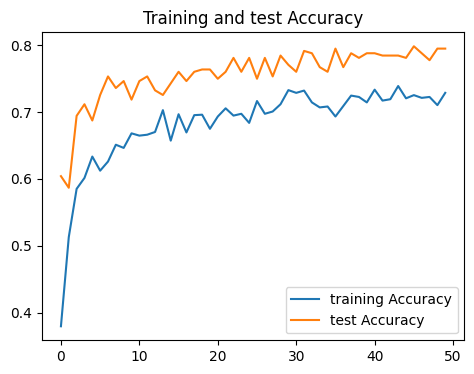

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = "training Accuracy")
plt.plot(epochs_range, val_acc, label = "test Accuracy")
plt.legend(loc='lower right')
plt.title('Training and test Accuracy')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"test Accuracy : {test_acc * 100:.2f}%")

10/10 [==============================] - 3s 278ms/step - loss: 0.5610 - accuracy: 0.8000
test Accuracy : 80.00%


In [ ]:
def predict_single_image(image_path):
  img_array = resize_image(image_path)
  img_array = img_array.reshape((1,) + img_array.shape)
  prediction = model.predict(img_array)
  class_idx = prediction.argmax(axis=-1)[0]
  class_labels = list(train_generator.class_indices.keys())
  return class_labels[class_idx], prediction[0]

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
example_image_path = './test1.jpg'
predicted_class, probabilities = predict_single_image(example_image_path)

print(f"Predicted Class: {predicted_class}")
print(f"Probabilities: {probabilities}")

In [ ]:
# 모델 가중치 저장하기

model.save_weights('resnet50.h5')

model.load_weights('resnet50.h5')